<center style="padding: 3rem 1rem; border-radius:25px; border: 3px solid #ff2b6b;">
    <h1 style="color: #ff2b6b; font-size:3rem; margin:0;">🌼️ Flower Classification 🌸️</h1>
    <h2 style="color: #ff2b6b; font-size:2rem; magin:0;">Transfer Learning - ResNet50 | FineTuning</h2>
    <h2 style="color: #ff2b6b; font-size:2rem; magin:0;">⚡️ Pytorch Lightning | KFolds</h2>
    <a href="https://kaggle.com/shreydan" style="color: white; 
                                                 padding: 1rem 2rem; 
                                                 background-color: #ff2b6b;
                                                 text-decoration: none;
                                                 border-radius: 50px;
                                                 font-size: 1.25rem;
                                                 ">@shreydan</a>
</center>

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

from collections import Counter

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image

In [4]:
torchvision.__version__

'0.12.0'

In [5]:
import pytorch_lightning as pl
import torchmetrics

# **Getting Data**
___

In [6]:
ds_path = Path('../input/flowers/flowers').resolve()

In [7]:
paths = list(ds_path.glob('*/*'))
classes = [path.parent.stem for path in paths]

Counter(classes), len(classes), len(set(classes))

(Counter({'astilbe': 737,
          'daffodil': 970,
          'black_eyed_susan': 1000,
          'bellflower': 873,
          'common_daisy': 980,
          'coreopsis': 1047,
          'dandelion': 1052,
          'water_lily': 982,
          'carnation': 923,
          'calendula': 978,
          'california_poppy': 1022,
          'sunflower': 1027,
          'tulip': 1048,
          'rose': 999,
          'magnolia': 1048,
          'iris': 1054}),
 15740,
 16)

In [8]:
df = pd.DataFrame({'path': paths, 'class': classes})
df['class'] = df['class'].astype('category')
df['label'] = df['class'].cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15740 entries, 0 to 15739
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   path    15740 non-null  object  
 1   class   15740 non-null  category
 2   label   15740 non-null  int8    
dtypes: category(1), int8(1), object(1)
memory usage: 154.5+ KB


In [9]:
class_labels = dict(zip(range(16), df['class'].cat.categories))
class_labels

{0: 'astilbe',
 1: 'bellflower',
 2: 'black_eyed_susan',
 3: 'calendula',
 4: 'california_poppy',
 5: 'carnation',
 6: 'common_daisy',
 7: 'coreopsis',
 8: 'daffodil',
 9: 'dandelion',
 10: 'iris',
 11: 'magnolia',
 12: 'rose',
 13: 'sunflower',
 14: 'tulip',
 15: 'water_lily'}

In [10]:
df.tail(10)

path class  label
15730  /kaggle/input/flowers/flowers/iris/7183449485_...  iris     10
15731  /kaggle/input/flowers/flowers/iris/8753156569_...  iris     10
15732  /kaggle/input/flowers/flowers/iris/34813147012...  iris     10
15733  /kaggle/input/flowers/flowers/iris/17745911753...  iris     10
15734  /kaggle/input/flowers/flowers/iris/13993696698...  iris     10
15735  /kaggle/input/flowers/flowers/iris/40502574023...  iris     10
15736  /kaggle/input/flowers/flowers/iris/3516534783_...  iris     10
15737  /kaggle/input/flowers/flowers/iris/4614530689_...  iris     10
15738  /kaggle/input/flowers/flowers/iris/3685522287_...  iris     10
15739  /kaggle/input/flowers/flowers/iris/3572644076_...  iris     10

# **Datasets**
___

In [11]:
from sklearn.model_selection import train_test_split

## Split

- The dataset will be split into train and test data
- Train dataset will further be split with StratifiedKFolds into train and val datasets

In [12]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=1357, stratify=df['label'])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
len(train), len(test)

(14166, 1574)

## **Custom Dataset**

In [13]:
class Flowers:
    def __init__(self, df, augmentations=None):
        self.paths = df['path'].values
        self.labels = df['label'].values
        
        if augmentations is None:
            self.augmentations = transforms.Compose([transforms.Resize((180,180)),
                                                     transforms.ToTensor()
                                                    ])
        else:
            self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        sample = self.paths[idx]
        sample = Image.open(sample).convert(mode='RGB')
        sample = self.augmentations(sample)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return (sample, label)

In [14]:
test_ds = Flowers(test)

# **Visualization**
___

In [15]:
five_from_each = test.groupby('class').apply(lambda s: s.sample(5)).reset_index(drop=True)
five_from_each['class'].value_counts()

astilbe             5
bellflower          5
black_eyed_susan    5
calendula           5
california_poppy    5
carnation           5
common_daisy        5
coreopsis           5
daffodil            5
dandelion           5
iris                5
magnolia            5
rose                5
sunflower           5
tulip               5
water_lily          5
Name: class, dtype: int64

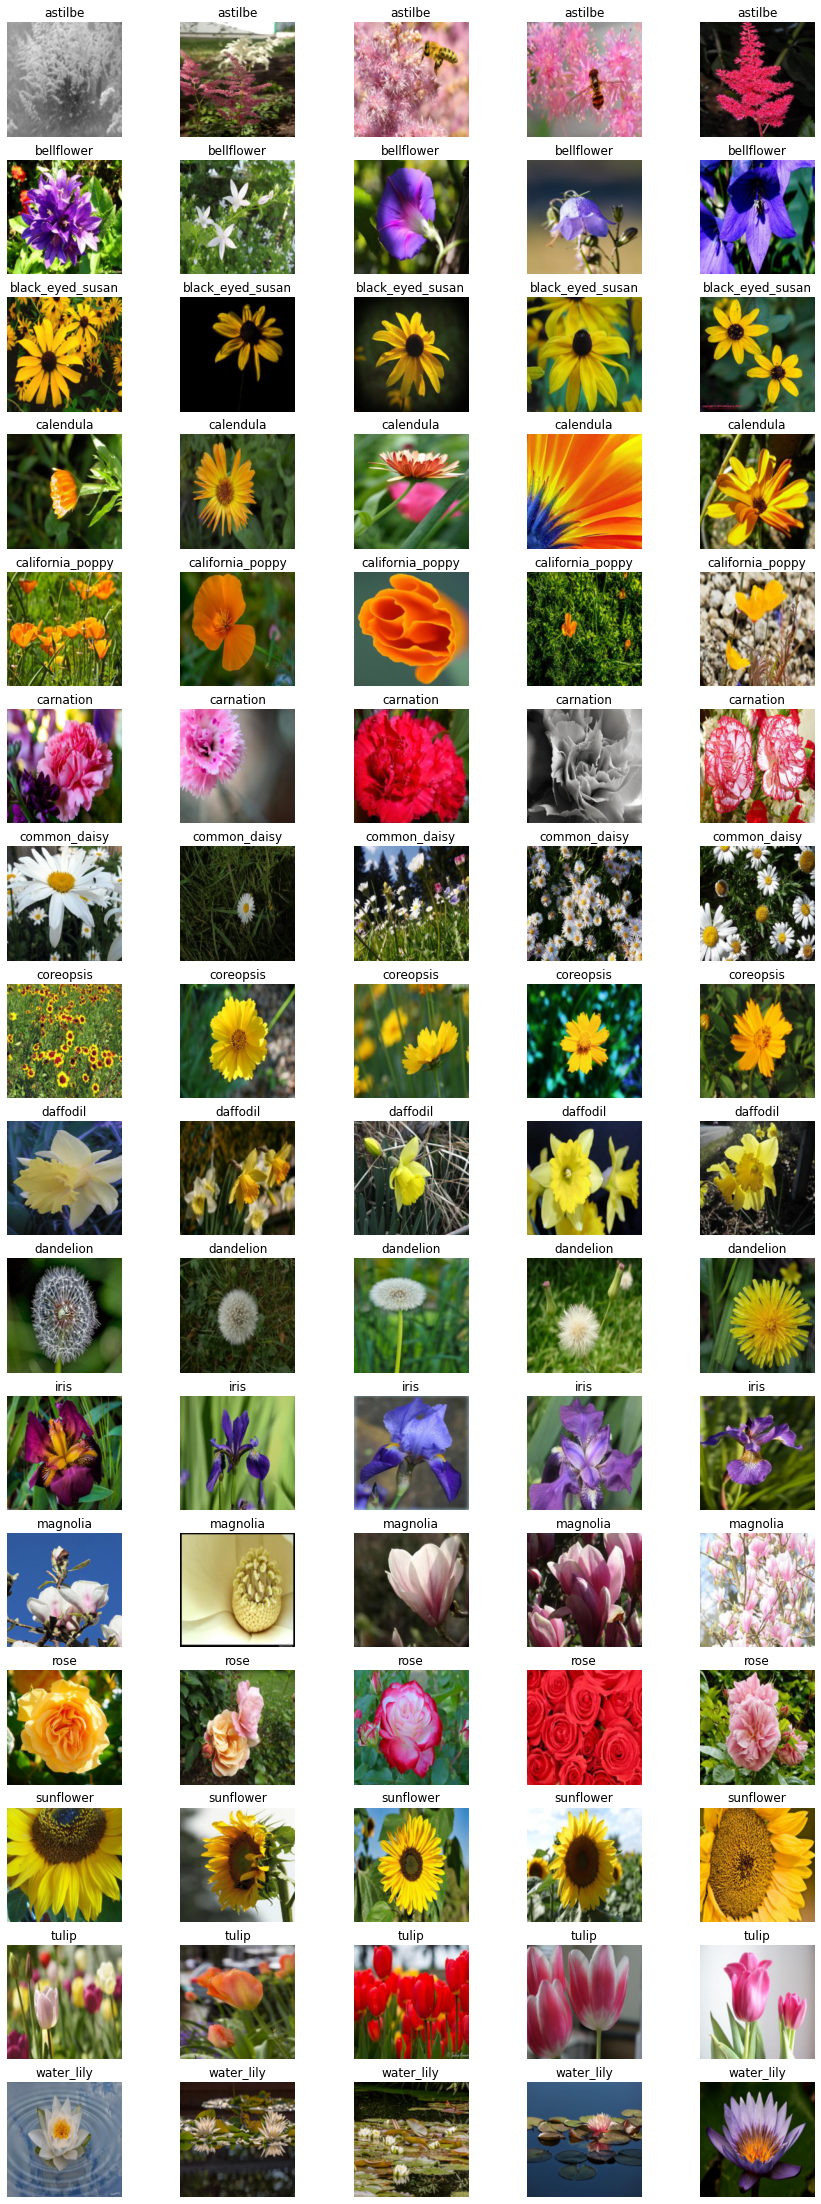

In [16]:
five_from_each_ds = Flowers(five_from_each)

figure = plt.figure(figsize=(15,40))
for i in range(1,len(five_from_each_ds)+1):
    img = five_from_each_ds[i-1][0].permute(1,2,0)
    label = class_labels[five_from_each_ds[i-1][1].item()]
    figure.add_subplot(16,5,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

## **Augmentations**

In [17]:
train_augmentations = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomEqualize(0.2),
    transforms.RandomPosterize(8,p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet Mean
                         std=[0.229, 0.224, 0.225]   # ImageNet Std
                        ),
    transforms.RandomResizedCrop(180),
])
val_augmentations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet Mean
                         std=[0.229, 0.224, 0.225]   # ImageNet Std
                        ),
    transforms.RandomResizedCrop(180),
])

## **Visualization after train augmentations**

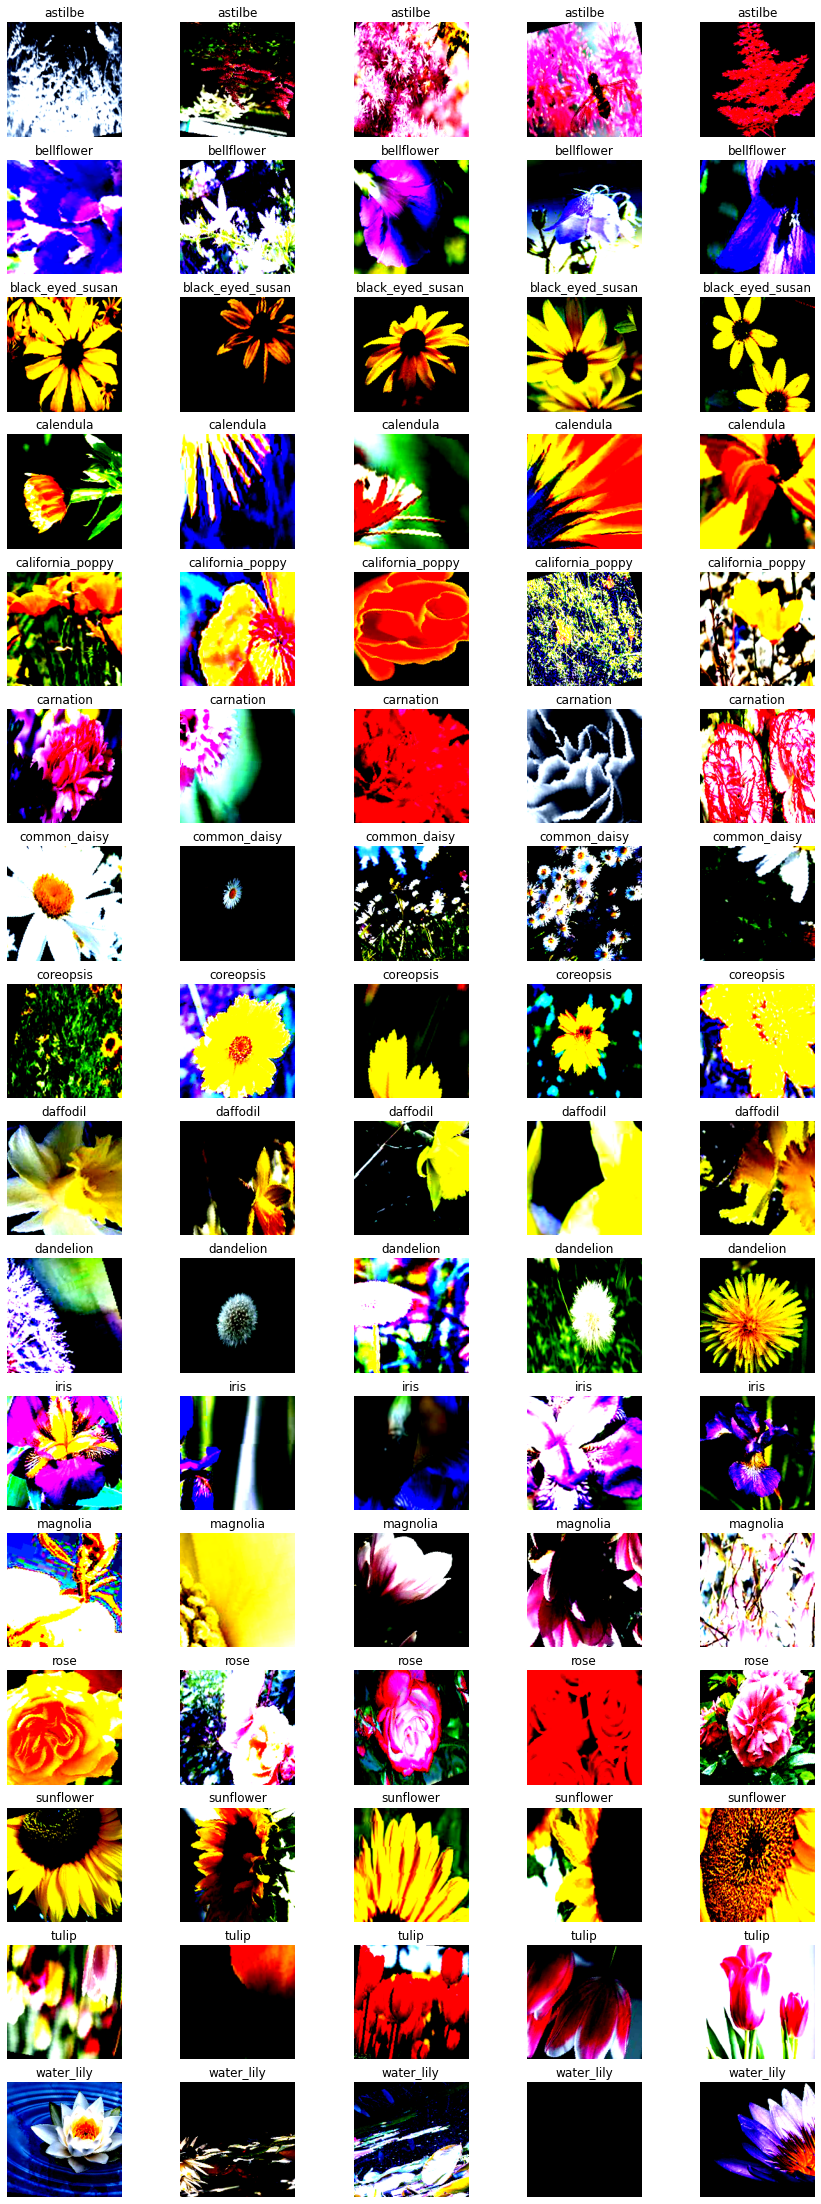

In [18]:
five_from_each_ds = Flowers(five_from_each, train_augmentations)

figure = plt.figure(figsize=(15,40))
for i in range(1,len(five_from_each_ds)+1):
    img = five_from_each_ds[i-1][0].permute(1,2,0)
    label = class_labels[five_from_each_ds[i-1][1].item()]
    figure.add_subplot(16,5,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

# **Transfer Learning Model**

- `ResNet50 Pretrained`
- `FineTuning` with updated fully connected block

___

In [19]:
class ResNet50Model(pl.LightningModule):
    
    def __init__(self, pretrained=True, in_channels = 3, num_classes = 16):
        super(ResNet50Model, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        self.model = models.resnet50(pretrained=pretrained)
        
        if pretrained is True:
            for param in self.model.parameters():
                param.requires_grad = False
        
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.Dropout(0.5),
            nn.Linear(512, self.num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
        
    def forward(self, x):
        return self.model(x)
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        
        preds = self.model(x)
        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_epoch=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        
        x,y = batch
        
        preds = self.model(x)
        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
        
    
    def test_step(self, batch, batch_idx):
        
        x,y = batch
        preds = self.model(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test_acc', self.test_acc, on_epoch=True)

In [20]:
m = ResNet50Model()
m.model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **KFolds Training**
___

In [21]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(5)

logs = dict()

for fold, (train_fold, val_fold) in enumerate(kf.split(X=train, y=train['label']), start=1):
    
    train_df = train.loc[train_fold]
    val_df = train.loc[val_fold]
    
    train_ds = Flowers(train_df, augmentations=train_augmentations)
    val_ds = Flowers(val_df, augmentations=val_augmentations)
    test_ds = Flowers(test)
    
    train_dataloader = torch.utils.data.DataLoader(train_ds,batch_size=64,num_workers=2)
    val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=64,num_workers=2)
    test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=128, num_workers=2)
    
    model = ResNet50Model()
    trainer = pl.Trainer(accelerator='gpu', max_epochs=5)
    
    print(f"\n\n\n{'=='*20} FOLD {fold} / 5 {'=='*20}")
    
    trainer.fit(model, train_dataloader, val_dataloader)
    metrics = trainer.logged_metrics
    trainer.test(model, test_dataloader)
    
    logs[f'fold{fold}'] = {
        'train_loss': metrics['train_loss_epoch'].item(),
        'val_loss': metrics['val_loss'].item(),
        'train_acc': metrics['train_acc_epoch'].item(),
        'val_acc': metrics['val_acc'].item()
    }
    
    print(f"Train Loss: {logs[f'fold{fold}']['train_loss']} | Train Accuracy: {logs[f'fold{fold}']['train_acc']}")
    print(f"Val Loss: {logs[f'fold{fold}']['val_loss']} | Val Accuracy: {logs[f'fold{fold}']['val_acc']}")
    




======================================== FOLD 1 / 5 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5984752178192139     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 0.584355354309082 | Train Accuracy: 0.8114190101623535
Val Loss: 0.4606426954269409 | Val Accuracy: 0.8535638451576233



======================================== FOLD 2 / 5 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5883100628852844     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 0.5821825861930847 | Train Accuracy: 0.815053403377533
Val Loss: 0.47877147793769836 | Val Accuracy: 0.8439816236495972



======================================== FOLD 3 / 5 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6111816763877869     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 0.5802328586578369 | Train Accuracy: 0.8140827417373657
Val Loss: 0.448848158121109 | Val Accuracy: 0.8609248399734497



======================================== FOLD 4 / 5 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5959339141845703     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 0.5767685770988464 | Train Accuracy: 0.8153181076049805
Val Loss: 0.46119430661201477 | Val Accuracy: 0.8552771210670471



======================================== FOLD 5 / 5 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5895807147026062     │
└───────────────────────────┴───────────────────────────┘

Train Loss: 0.5751252770423889 | Train Accuracy: 0.8160240054130554
Val Loss: 0.5148413181304932 | Val Accuracy: 0.8319802284240723


In [22]:
logs

{'fold1': {'train_loss': 0.584355354309082,
  'val_loss': 0.4606426954269409,
  'train_acc': 0.8114190101623535,
  'val_acc': 0.8535638451576233},
 'fold2': {'train_loss': 0.5821825861930847,
  'val_loss': 0.47877147793769836,
  'train_acc': 0.815053403377533,
  'val_acc': 0.8439816236495972},
 'fold3': {'train_loss': 0.5802328586578369,
  'val_loss': 0.448848158121109,
  'train_acc': 0.8140827417373657,
  'val_acc': 0.8609248399734497},
 'fold4': {'train_loss': 0.5767685770988464,
  'val_loss': 0.46119430661201477,
  'train_acc': 0.8153181076049805,
  'val_acc': 0.8552771210670471},
 'fold5': {'train_loss': 0.5751252770423889,
  'val_loss': 0.5148413181304932,
  'train_acc': 0.8160240054130554,
  'val_acc': 0.8319802284240723}}

___
# **Thank You!** ✨️

For taking the time to check out my notebook! This was my first attempt at transfer-learning and it was really fun.

Would really appreciate your feedback! Feel free to leave a comment 💬️

<center>
<img src="https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle">
</center>

___